<a href="https://colab.research.google.com/github/svlpn/MIPT4SEMML/blob/master/hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**transfer learning with PyTorch and TorchVision**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import torch.nn as nn
import torch
from torchvision import datasets, models, transforms
from PIL import Image
import torchvision
import time
import os
from torch.utils.data import Dataset
from sklearn.preprocessing import MultiLabelBinarizer
import sklearn.metrics as metrics
import random
from IPython.core.display import display, HTML
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/zalando_english.csv')

Извлекаем adjs и nouns

In [6]:
def extract_nouns(text):
  tokenized = nltk.word_tokenize(text)
  return [word.lower() for (word, pos) in nltk.pos_tag(tokenized) if pos[:2] == 'NN']
def extract_adjs(text):
  tokenized = nltk.word_tokenize(text)
  return [word.lower() for (word, pos) in nltk.pos_tag(tokenized) if pos[:2] == 'JJ']
df['nouns'] = df['descriptions'].apply(lambda v: extract_nouns(v))
df['adjs'] = df['descriptions'].apply(lambda v: extract_adjs(v))

In [7]:
df.head()

,Unnamed: 0,url,descriptions,split,nouns,adjs
0,0,https://i2.ztat.net/large/Y0/32/1C/00/UE/11/Y0...,"short, sexy, summer, sexy, party, yellow dress...",7,"[summer, sexy, party, dress, sleeves, yellow, ...","[short, sexy, yellow, shoulder-free, fabric, y..."
1,1,https://i6.ztat.net/large/V1/02/1C/0T/QK/11/V1...,blue knee-length ladies dress with white dots ...,6,"[ladies, dress, dots, pattern, round, neckline...","[blue, knee-length, white, short, white, polka..."
2,2,https://i6.ztat.net/large/TF/72/1C/01/5K/11/TF...,This product is a dress. It's striped gray and...,2,"[product, dress, blue, beach, dress, knees, ro...","[striped, gray, white, light, white, gray, whi..."
3,3,https://i2.ztat.net/large/VE/12/1C/14/9C/11/VE...,Thigh-length fabric dress in gray with hip poc...,7,"[thigh-length, fabric, dress, pockets, round, ...","[gray, hip, elbow-length, casual, three-fold, ..."
4,4,https://i6.ztat.net/large/S2/92/1C/0B/AK/11/S2...,It is an elegant dark blue medium length dress...,7,"[dark, medium, length, dress, sleeves, top, ro...","[elegant, blue, black, figure-hugging, knee-le..."


Популярные теги

In [8]:
def top_tags(tags):
    scores = TfidfVectorizer(analyzer='word', stop_words='english').fit_transform(tags).toarray().sum(axis=1)
    sorted_ids = np.argsort(scores).flatten()[::-1]
    return np.array(tags)[sorted_ids[:10]]

In [ ]:
df['nouns'] = df['nouns'].apply(lambda x: top_tags(x))
df['adjs'] = df['adjs'].apply(lambda x: top_tags(x))

In [9]:
num_classes = 25
values, counts = np.unique(np.concatenate(df['nouns'].to_numpy()), return_counts=True)
ind = np.argpartition(-counts, kth=num_classes)[:num_classes]
noun_classes = values[ind]
noun_classes

array(['knee', 'sleeves', 'arms', 'length', 'round', 'collar', 'mini',
       'waist', 'sleeveless', 'dress', 'belt', 'v-neck', 'summer',
       'pattern', 'cut', 'knees', 'skirt', 'blue', 'neckline',
       'knee-length', 'straps', 'lace', 'shoulders', 'neck', 'fabric'],
      dtype='<U27')

In [10]:
all_adjs = df['adjs'].to_numpy()
all_adjs = np.concatenate(all_adjs)
values, counts = np.unique(all_adjs, return_counts=True)

ind = np.argpartition(-counts, kth=num_classes)[:num_classes]
adjs_classes = values[ind]
adjs_classes

array(['tight', 'narrow', 'blue', 'white', 'small', 'floral', 'free',
       'wide', 'half-length', 'sleeveless', 'medium-length', 'light',
       'gray', 'deep', 'long', 'red', 'black', 'shoulder-free', 'dark',
       'knee-length', 'colorful', 'figure-hugging', 'short', 'mid-thigh',
       'green'], dtype='<U27')

In [11]:
df['nouns'] = df['nouns'].map(lambda v: list(noun_classes[np.in1d(noun_classes, v)])).values
df['adjs'] = df['adjs'].map(lambda v: list(adjs_classes[np.in1d(adjs_classes, v)])).values

In [ ]:
df = df[df['nouns'].map(len) >= 1]
df = df[df['adjs'].map(len) >= 1]

In [ ]:
df['tags'] = df['nouns'] + df['adjs']

In [12]:
mlb = MultiLabelBinarizer()
y = pd.DataFrame(mlb.fit_transform(df['tags']), columns=mlb.classes_)
y.head()

,arms,belt,black,blue,collar,colorful,cut,dark,deep,dress,fabric,figure-hugging,floral,free,gray,green,half-length,knee,knee-length,knees,lace,length,light,long,medium-length,mid-thigh,mini,narrow,neck,neckline,pattern,red,round,short,shoulder-free,shoulders,skirt,sleeveless,sleeves,small,straps,summer,tight,v-neck,waist,white,wide
0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0
2,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0


Загружем картинки

In [13]:
!unzip /content/drive/MyDrive/Datasets/zalando_compressed.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: zalando_compressed/L4221C0B4-G11@12.jpg  
  inflating: zalando_compressed/L4221C0B5-E11@11.1.jpg  
  inflating: zalando_compressed/L4221C0B6-Q11@12.1.jpg  
  inflating: zalando_compressed/L4221C0B7-K11@2.jpg  
  inflating: zalando_compressed/L4221C0B8-Q11@12.jpg  
  inflating: zalando_compressed/L4221C0B9-Q11@10.jpg  
  inflating: zalando_compressed/L4221C0BA-Q11@10.jpg  
  inflating: zalando_compressed/L4221C0BB-Q11@14.jpg  
  inflating: zalando_compressed/L4221C0BC-Q11@14.jpg  
  inflating: zalando_compressed/L4221C0BD-K11@12.jpg  
  inflating: zalando_compressed/L4221C0BE-Q11@14.jpg  
  inflating: zalando_compressed/L4221C0BF-Q11@11.jpg  
  inflating: zalando_compressed/L4221C0BG-M11@10.jpg  
  inflating: zalando_compressed/L4221C0BH-Q11@22.jpg  
  inflating: zalando_compressed/L4221C0BI-Q11@12.jpg  
  inflating: zalando_compressed/L4221C0BJ-T11@12.1.jpg  
  inflating: zalando_compressed/L4221C0BK-K11@1

In [14]:
img_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
for i, url in enumerate(df['url'].values):
    filename = url.split('/')[-1]
    img = Image.open(f"/content/zalando_compressed/{filename}")
    img = img.convert('RGB')
    pil_images.append(img)
    image_tensors.append(img_transforms(img))

In [15]:
batch_size = 64
num_workers = 4
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = torch.Tensor(targets)
        self.transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomGrayscale(), 
                                    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])


In [ ]:
    def __getitem__(self, index):
        x = self.transform(self.data[index])
        y = self.targets[index]
        return x, y
    def __len__(self):
        return len(self.data)

In [16]:
y = y.to_numpy()

x_train, x_test, y_train, y_test = train_test_split(pil_images, y, test_size=0.3, random_state=42)

train_dataset = MyDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)


test_dataset = MyDataset(x_test, y_test)
dataloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)


image_datasets = {'train': x_train, 'val': x_test}
dataloaders = {'train': dataloader_train, 'val': dataloader_test}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [17]:
input_size = 224
num_classes = len(mlb.classes_)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [19]:
class Resnext50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()
        self.featureLayer = self.base_model._modules.get('avgpool')

    def forward(self, x):
        return self.sigm(self.base_model(x))

    def getImageVec(self, img):
        image = img.unsqueeze(0).to(device)
        embedding = torch.zeros(1, 2048, 1, 1)
        def copyData(m, i, o): embedding.copy_(o.data)
        h = self.featureLayer.register_forward_hook(copyData)
        model(image)
        h.remove()

        return embedding.numpy()[0, :, 0, 0]

model = Resnext50(num_classes)
model = model.to(device)
model.train()

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


Resnext50(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

Изображения в векторы

In [20]:
image_vectors = []
for image in image_tensors:
    image_vectors.append(model.getImageVec(image))

In [21]:
randoms = [random.randint(1, len(image_vectors)) for _ in range(15)]

sim_matrix = [];
for i in randoms:
    sim_dict = {}
    for j in range(len(image_vectors)):
        sim_dict[j] = cosine_similarity([image_vectors[i]], [image_vectors[j]])[0][0]
    sim_matrix.append(sim_dict)

similar_images = []
for row in sim_matrix:
    sorted_list = sorted(row.items(), key=lambda v: v[1], reverse=True)
    similar = []
    for item in sorted_list[0:5]:
        id = item[0]
        similar.append((df.iloc[id]['url'], item[1]))
    similar_images.append({'id': sorted_list[0][0], 'similar': similar})

In [22]:
res = ''
for row in similar_images:
    res += 'similarity:'
    for (url, sim) in row['similar']:
        res += (
        '<figure style="display: inline-block">'
            '<center>'
            f'<img src="{url}" height="100" width="100">'
            f'<figcaption>{round(sim, 3)}</figcaption>' 
            '</center>'
        '</figure>'
        )
    res+='<br/>'

display(HTML(res))

In [23]:
max_epoch_number = 20
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [ ]:
def checkpoint_save(model, epoch):
    f = os.path.join('/content/drive/MyDrive/ml/zalando_checkpoints/', 'checkpoint-{:06d}.pth'.format(epoch))
    if 'module' in dir(model):
        torch.save(model.module.state_dict(), f)
    else:
        torch.save(model.state_dict(), f)
    print('saved checkpoint:', f)

def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return {
            'micro/f1': metrics.f1_score(y_true=target, y_pred=pred, average='micro'),
            'macro/f1': metrics.f1_score(y_true=target, y_pred=pred, average='macro'),
            'samples/f1': metrics.f1_score(y_true=target, y_pred=pred, average='samples'),
        }

In [ ]:
epoch = 0
iteration = 0
test_freq = 10
save_freq = 1
while True:
    batch_losses = []
    for imgs, targets in dataloaders['train']:
        imgs, targets = imgs.to(device), targets.to(device)

        optimizer.zero_grad()

        model_result = model(imgs)
        loss = criterion(model_result, targets.type(torch.float))

        batch_loss_value = loss.item()
        loss.backward()
        optimizer.step()

        batch_losses.append(batch_loss_value)

        if iteration % test_freq == 0:
            model.eval()
            with torch.no_grad():
                model_result = []
                targets = []
                for imgs, batch_targets in dataloaders['train']:
                    imgs = imgs.to(device)
                    model_batch_result = model(imgs)
                    model_result.extend(model_batch_result.cpu().numpy())
                    targets.extend(batch_targets.cpu().numpy())

            result = calculate_metrics(np.array(model_result), np.array(targets))
            print("epoch:{:2d} iter:{:3d} test: "
                  "micro f1: {:.3f} "
                  "macro f1: {:.3f} "
                  "samples f1: {:.3f}".format(epoch, iteration,
                                              result['micro/f1'],
                                              result['macro/f1'],
                                              result['samples/f1']))

            model.train()
        iteration += 1

    loss_value = np.mean(batch_losses)
    print("epoch:{:2d} iter:{:3d} train: loss:{:.3f}".format(epoch, iteration, loss_value))
    if epoch % save_freq == 0:
        checkpoint_save(model, epoch)
    epoch += 1
    if max_epoch_number < epoch:
        break


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 0 iter:  0 test: micro f1: 0.452 macro f1: 0.104 samples f1: 0.452
epoch: 0 iter: 10 test: micro f1: 0.515 macro f1: 0.173 samples f1: 0.511
epoch: 0 iter: 20 test: micro f1: 0.496 macro f1: 0.176 samples f1: 0.485
epoch: 0 iter: 30 test: micro f1: 0.522 macro f1: 0.176 samples f1: 0.519
epoch: 0 iter: 40 test: micro f1: 0.564 macro f1: 0.214 samples f1: 0.559
epoch: 0 iter: 50 test: micro f1: 0.580 macro f1: 0.245 samples f1: 0.578
epoch: 0 iter: 60 test: micro f1: 0.563 macro f1: 0.246 samples f1: 0.555
epoch: 0 iter: 70 test: micro f1: 0.585 macro f1: 0.238 samples f1: 0.582
epoch: 0 iter: 80 test: micro f1: 0.548 macro f1: 0.228 samples f1: 0.545
epoch: 0 iter: 90 test: micro f1: 0.568 macro f1: 0.251 samples f1: 0.563
epoch: 0 iter: 97 train: loss:0.364
saved checkpoint: /content/drive/MyDrive/ml/zalando_checkpoints/checkpoint-000000.pth
epoch: 1 iter:100 test: micro f1: 0.568 macro f1: 0.247 samples f1: 0.563
epoch: 1 iter:110 test: micro f1: 0.561 macro f1: 0.225 samples 

In [ ]:
checkpoint = torch.load(os.path.join('/content/drive/MyDrive/ml/zalando_checkpoints/', 'checkpoint-{:06d}.pth'.format(20)))
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [24]:
def imshow(inputs):
    img = inputs.transpose(1, 2, 0)
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    inp = np.clip(img, 0, 1)
    plt.imshow(img)

In [25]:
def visualize_model(model, num_images=6):
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = outputs.cpu()
            preds = np.array(preds)[0]
            labels = labels.cpu().numpy()
            top3 = np.sort(preds)[::-1][min(2, len(preds)-1)]
            preds[preds < top3] = 0
            preds[preds >= top3] = 1
            tags = mlb.inverse_transform(np.array([preds]))[0][:3]
            tags_real = mlb.inverse_transform(np.array([labels[i]]))[0][:3]
            plt.subplot(2, 3, i + 1)
            plt.axis('off')
            plt.title('Predicted: ' + ', '.join(map(str, tags)) + '\n' + 'Real: ' + ', '.join(tags_real))
            img = np.array(inputs.cpu().data[i])
            imshow(img)
            if i >= num_images - 1:
                return

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


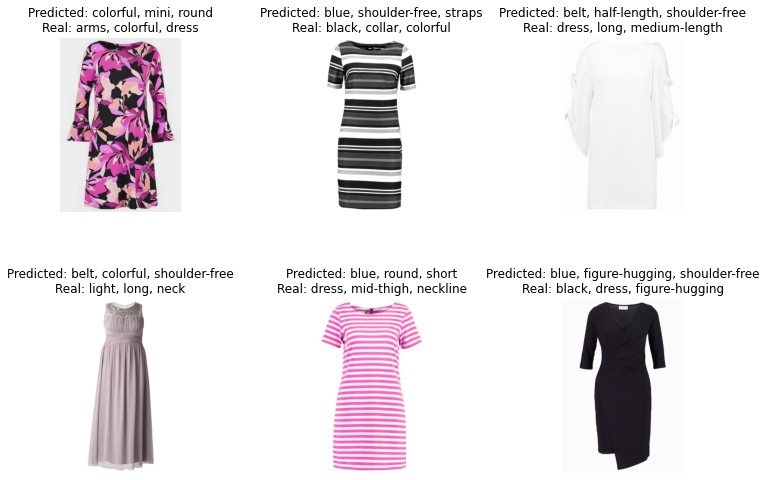

In [27]:
fig, ax = plt.subplots(figsize=(12,8))
plt.subplots_adjust(hspace=.5, wspace=.5)
visualize_model(model)